In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import cv2
from skimage.feature import hog

from sklearn import svm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [2]:
seed = 15

np.random.seed(seed)
tf.random.set_seed(seed)

# Lendo e tratando dados

In [3]:
def process_image(image_path):
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    return img_array

In [4]:
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            img_binary = process_image(img_path)
            images.append(img_binary.flatten())
    return images

In [5]:
def load_strings_from_folder(folder_path):
    strings = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r') as file:
                    content = file.read().strip()
                    strings.append(content)
                    filenames.append(filename)
            except Exception as e:
                print(f"Erro ao ler o arquivo {file_path}: {e}")
    return strings, filenames

In [6]:
treinamento = load_images_from_folder('dados/CAPTCHA-10k/treinamento')
treinamento = np.array(treinamento)
validacao = load_images_from_folder('dados/CAPTCHA-10k/validacao')
validacao = np.array(validacao)
teste = load_images_from_folder('dados/CAPTCHA-10k/teste')
teste = np.array(teste)
labels = load_strings_from_folder('dados/CAPTCHA-10k/labels10k')[0]

In [7]:
treino_x = treinamento
treino_y = labels[:8000]

validacao_x = validacao
validacao_y = labels[8000:9000]

teste_x = teste
teste_y = labels[9000:]

In [8]:
def print_img(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.show()

In [9]:
def apply_unsharp_mask(image, kernel_size=(5, 5), sigma=1.5):
    kernel = np.array([[0, -1, 0],
                       [-1, 6,-1],
                       [0, -1, 0]])
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = cv2.filter2D(blurred, -1, kernel)
    
    return sharpened

In [10]:
def particionar_img(image_array):
    image_array = np.reshape(image_array, (50, 180))
    # print_img(image_array)
    particoes = []
    offset = 30
    for i in range(0, 6):
        particao = image_array[10: 46, 5+offset*i:45+offset*i]
        particao = apply_unsharp_mask(particao)
        particoes.append(particao)
        # print_img(particao)
    particoes[5] = np.pad(particoes[5], ((0, 0), (7, 8)), 'constant', constant_values=255)
    return particoes

In [11]:
def aplicar_particao(images):
    images_particionadas = []
    for i in range(len(images)):
        images_particionadas.extend(particionar_img(images[i]))
    return np.array(images_particionadas)

In [12]:
def particonar_strings(strings):
    strings_particionadas = []
    for i in range(0, len(strings)):
        for j in range(0, 6):
            strings_particionadas.append(strings[i][j])
    
    return np.array(strings_particionadas)

In [13]:
set_caracteres = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?',
                  'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                  'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(set_caracteres)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

char_to_int = dict((c, i) for i, c in enumerate(set_caracteres))
int_to_char = dict((i, c) for i, c in enumerate(set_caracteres))

In [14]:
X_train = aplicar_particao(treino_x)
X_test = aplicar_particao(teste_x)
X_val = aplicar_particao(validacao_x)

y_train = particonar_strings(treino_y)
y_test = particonar_strings(teste_y)
y_val = particonar_strings(validacao_y)

In [15]:
y_train_int = label_encoder.transform(y_train)
y_test_int = label_encoder.transform(y_test)
y_val_int = label_encoder.transform(y_val)

y_train_onehot = onehot_encoder.transform(y_train_int.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test_int.reshape(-1, 1))
y_val_onehot = onehot_encoder.transform(y_val_int.reshape(-1, 1))

# HOG

In [16]:
def extract_hog_features(images):
    hog_features = []
    for image in images:    
        fd = hog(image, orientations=12, pixels_per_cell=(6, 5), cells_per_block=(2, 2))
        hog_features.append(fd)
    return np.array(hog_features)

In [17]:
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)
X_val_hog = extract_hog_features(X_val)

## Classificador SVM

In [18]:
model_svm = svm.SVC(kernel='linear')
model_svm.fit(X_train_hog, y_train_int)

SVC(kernel='linear')

In [19]:
y_pred_svm = model_svm.predict(X_test_hog)
print("Accuracy:", accuracy_score(y_test_int, y_pred_svm))

accuracy_vector_svm = (y_pred_svm == y_test_int).astype(int)


Accuracy: 0.936


## Classificador NN

In [20]:
input_shape = (1680,) 

model_nn = Sequential()
model_nn.add(Flatten(input_shape=input_shape))
model_nn.add(Dense(128, activation='relu'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(128, activation='relu'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(37, activation='softmax'))
model_nn.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

In [21]:
model_nn.fit(X_train_hog, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_val_hog, y_val_onehot))

Epoch 1/10
1500/1500 [==============================] - 10s 5ms/step - loss: 0.7151 - accuracy: 0.7910 - val_loss: 0.2554 - val_accuracy: 0.9262
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3321 - accuracy: 0.9001 - val_loss: 0.2250 - val_accuracy: 0.9385
Epoch 3/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2712 - accuracy: 0.9184 - val_loss: 0.1908 - val_accuracy: 0.9455
Epoch 4/10
1500/1500 [==============================] - 8s 6ms/step - loss: 0.2393 - accuracy: 0.9269 - val_loss: 0.1874 - val_accuracy: 0.9450
Epoch 5/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2154 - accuracy: 0.9337 - val_loss: 0.1960 - val_accuracy: 0.9465
Epoch 6/10
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1924 - accuracy: 0.9400 - val_loss: 0.2083 - val_accuracy: 0.9402
Epoch 7/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1802 - accuracy: 0.9424 - val_loss: 0.1841 - val_accuracy

In [22]:
y_pred_nn = model_nn.predict(X_test_hog)
y_pred_classes_nn = np.argmax(y_pred_nn, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

accuracy_vector_nn = (y_pred_classes_nn == y_true).astype(int)

print("Accuracy:", accuracy_score(y_true, y_pred_classes_nn))

188/188 [==============================] - 0s 1ms/step
Accuracy: 0.9428333333333333


# CNN

In [23]:
input_shape = (36, 40, 1)
num_classes = 37

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='Same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='Same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

# model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [24]:
model.fit(X_train, y_train_onehot, epochs=10, batch_size=64, validation_data=(X_val, y_val_onehot))

Epoch 1/10
750/750 [==============================] - 14s 11ms/step - loss: 4.6266 - accuracy: 0.0731 - val_loss: 1.1577 - val_accuracy: 0.6995
Epoch 2/10
750/750 [==============================] - 8s 11ms/step - loss: 0.9044 - accuracy: 0.7269 - val_loss: 0.2238 - val_accuracy: 0.9410
Epoch 3/10
750/750 [==============================] - 8s 11ms/step - loss: 0.4718 - accuracy: 0.8591 - val_loss: 0.1734 - val_accuracy: 0.9533
Epoch 4/10
750/750 [==============================] - 8s 10ms/step - loss: 0.3720 - accuracy: 0.8899 - val_loss: 0.1594 - val_accuracy: 0.9565
Epoch 5/10
750/750 [==============================] - 8s 10ms/step - loss: 0.3099 - accuracy: 0.9092 - val_loss: 0.1426 - val_accuracy: 0.9613
Epoch 6/10
750/750 [==============================] - 8s 10ms/step - loss: 0.2777 - accuracy: 0.9161 - val_loss: 0.1431 - val_accuracy: 0.9628
Epoch 7/10
750/750 [==============================] - 8s 10ms/step - loss: 0.2514 - accuracy: 0.9240 - val_loss: 0.1345 - val_accuracy: 0.964

In [25]:
y_pred_cnn = model.predict(X_test)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

accuracy_vector_cnn = (y_pred_classes_cnn == y_true).astype(int)

print("Accuracy:", accuracy_score(y_true, y_pred_classes_cnn))

188/188 [==============================] - 1s 2ms/step
Accuracy: 0.9656666666666667


# Avaliando modelos

In [26]:
def gerar_freq(accuracy_vector):
    caracteres_reconhecidos = np.zeros(7)
    for i in range(0, 1000):
        soma = 0
        for j in range(0, 6):
            if accuracy_vector[i * 6 + j] == 1:
                soma += 1
        
        caracteres_reconhecidos[soma] += 1

    frequencias = np.zeros(7)
    for i in range(0, 7):
        frequencia = 0
        for j in range(i, 7):
            frequencia += caracteres_reconhecidos[j]
        frequencias[i] = frequencia
    frequencias = frequencias/1000

    return frequencias

In [27]:
def print_grafico(frequencias):
    x_values = [0, 1, 2, 3, 4, 5, 6]
    plt.figure(figsize=(10, 5))
    plt.plot(x_values, frequencias)

    plt.title('Resultado')
    plt.xlabel('Número mínimo de caracteres reconhecidos por captcha')
    plt.ylabel('Taxa de Reconhecimento')
    plt.ylim(0, 1.1)
    plt.grid(True)

    plt.show()

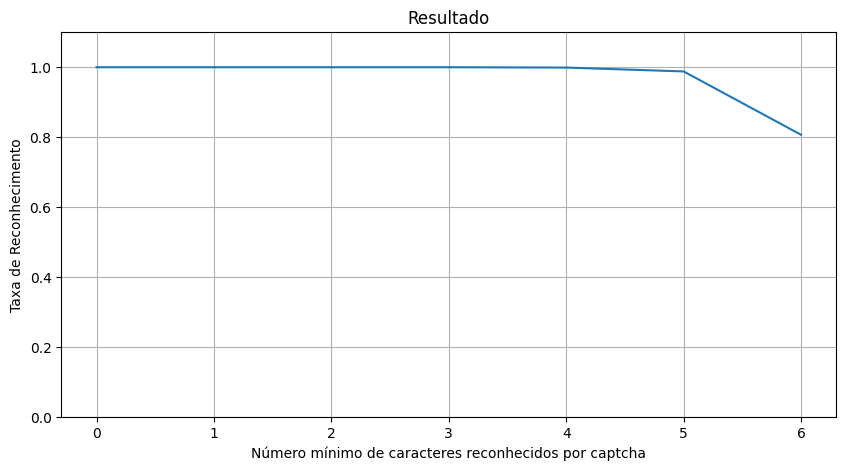

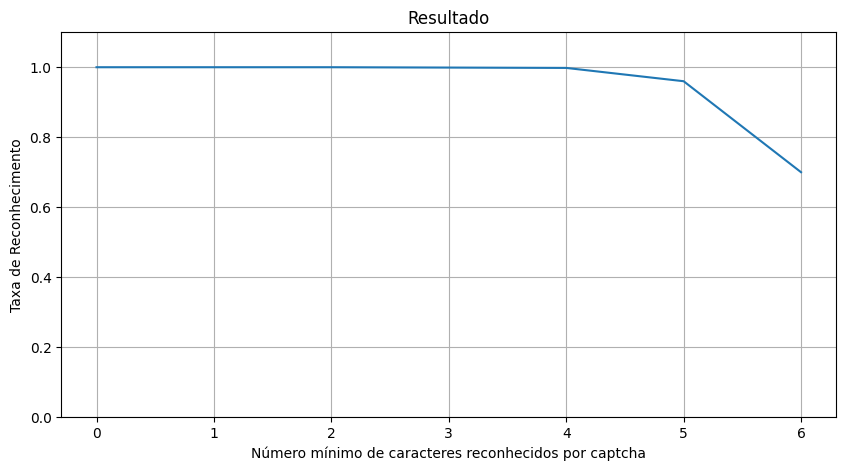

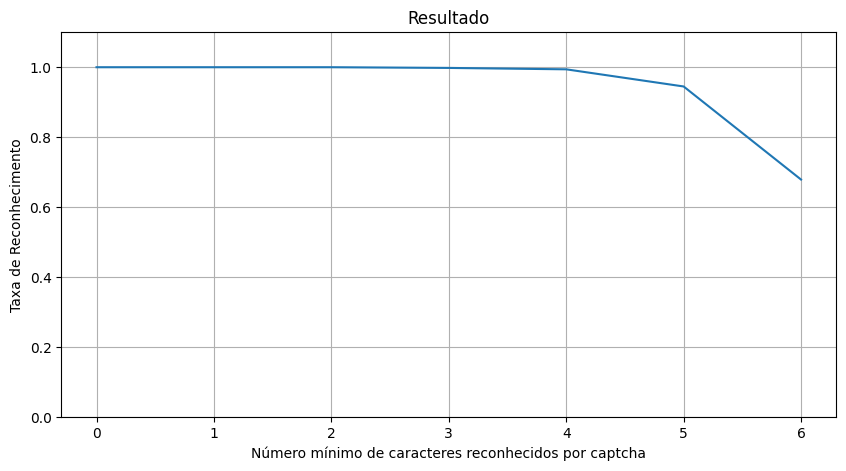

In [28]:
freq_cnn = gerar_freq(accuracy_vector_cnn)
freq_nn = gerar_freq(accuracy_vector_nn)
freq_svm = gerar_freq(accuracy_vector_svm)

print_grafico(freq_cnn)
print_grafico(freq_nn)
print_grafico(freq_svm)

In [88]:
def get_prediction(image_id):
    if image_id >= 0 and image_id < 8000:
        image = treinamento[image_id]
    elif image_id >= 8000 and image_id < 9000:
        image = validacao[image_id-8000]
    elif image_id >= 9000 and image_id < 10000:
        image = teste[image_id-9000]
    
    particoes = particionar_img(image)
    particoes = np.array(particoes)

    cnn_result = model.predict(particoes, verbose=False)
    cnn_predictions = np.argmax(cnn_result, axis=1)

    cnn_string = ''.join([int_to_char[predict] for predict in cnn_predictions])

    #####
    hog_particoes = extract_hog_features(particoes)

    hog_results = model_nn.predict(hog_particoes, verbose=False)
    hog_predictions = np.argmax(hog_results, axis=1)
    hog_string  = ''.join([int_to_char[predict] for predict in hog_predictions])

    image = image.reshape(50, 180)
    print_img(image)
    print(f"CNN: {cnn_string}")
    print(f"HOG: {hog_string}")
    
    return